In [1]:
# !pip install datasets
# !pip install transformers

In [22]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ExifTags
import torch
import torchvision.transforms as T 
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from monai.networks.nets import UNet
from monai.transforms import Compose, Resize, EnsureChannelFirst, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from huggingface_hub import login
import timm
from transformers import AutoTokenizer, BioGptForCausalLM
import open_clip

In [2]:
ds = load_dataset("hongrui/mimic_chest_xray_v_1")

In [3]:
torch.cuda.device_count()

1

In [4]:
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [5]:
# Load dataset (limiting to a subset for faster processing)
subset_size = 10000 
# ds_subset = ds["train"].select(range(subset_size))
ds_subset = ds["train"]

# Define split ratio
split_ratio = 0.8  # 80% train, 20% validation
split_index = int(len(ds_subset) * split_ratio)

# # Split the dataset
# train_subset = ds["train"].select(range(split_index))
# val_subset = ds["train"].select(range(split_index, len(ds_subset)))

# Split the dataset
train_subset = ds_subset.select(range(split_index))
val_subset = ds_subset.select(range(split_index, len(ds_subset)))

train_subset = train_subset.with_format("python")
val_subset = val_subset.with_format("python")


# Create new dataset dictionary
split_ds = {"train": train_subset, "validation": val_subset}

# Print sizes
print(f"Train Size: {len(split_ds['train'])}")
print(f"Validation Size: {len(split_ds['validation'])}")

Train Size: 71516
Validation Size: 17879


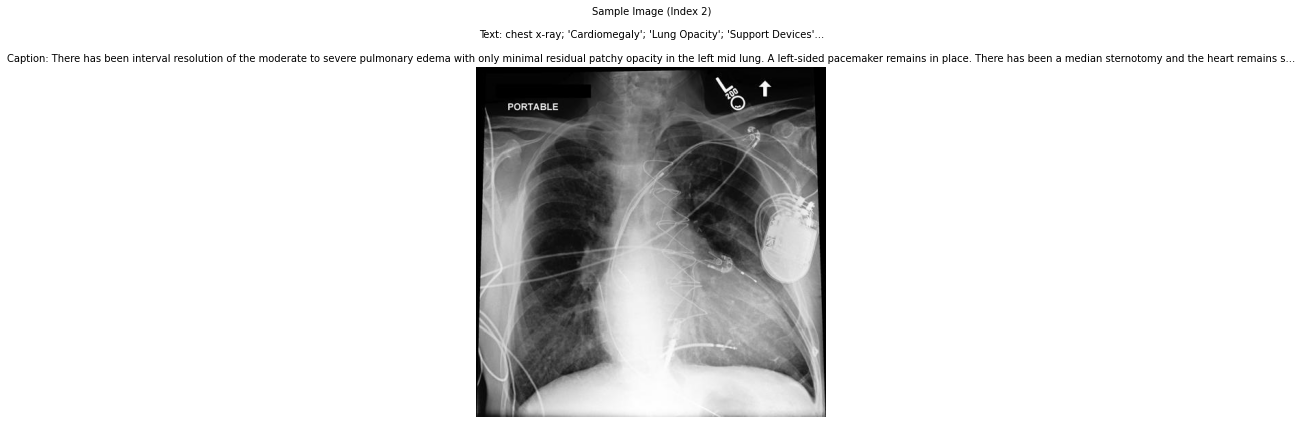

In [6]:
def visualize_sample(sample, index=None):
    image = sample["image"]  # Already a PIL.Image.Image
    text = sample.get("text", "No text found")
    caption = sample.get("report", "No caption found")

    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        raise TypeError("Expected a PIL.Image.Image")

    plt.figure(figsize=(6, 6))
    plt.imshow(image_array, cmap="gray")
    title = f"Sample Image"
    if index is not None:
        title += f" (Index {index})"
    plt.title(f"{title}\n\nText: {text[:120]}...\n\nCaption: {caption[:240]}...", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example: Visualize a specific sample from your train subset
sample_index = 2
sample = train_subset[sample_index]
visualize_sample(sample, index=sample_index)

In [7]:
# Define preprocessing transforms
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to 256x256
#     T.Grayscale(num_output_channels=1),  # Convert to grayscale
    T.ToTensor(),  # Convert to tensor (0-1 range)
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (range -1 to 1)
])

In [8]:
# Medical Tokenizer (Bio_ClinicalBERT)

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Preprocessing function
def preprocess(sample):
    image = sample["image"]
    caption = sample["report"]

    # Transform image using MONAI
    if isinstance(image, Image.Image):
        image_tensor = transform(image)
    else:
        raise TypeError("Unsupported image format")

    # Tokenize medical caption
    tokens = tokenizer(
        caption,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    return {
        "pixel_values": image_tensor,
        "input_ids": tokens["input_ids"].squeeze(0),
        "attention_mask": tokens["attention_mask"].squeeze(0),
        "raw_caption": caption
    }


In [19]:
def visualize_preprocessed(sample, processed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    # Original image
    axes[0].imshow(sample["image"])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Preprocessed image
    pre_img = processed["pixel_values"].permute(1, 2, 0).numpy()
    axes[1].imshow(pre_img, cmap="gray")
    axes[1].set_title("Preprocessed Image")
    axes[1].axis("off")

    # Add caption below both images
    caption = processed['raw_caption']
    fig.text(0.5, 0.02, f"Caption: {caption[:200]}...", wrap=True, ha='center', fontsize=10)

    plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for caption
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


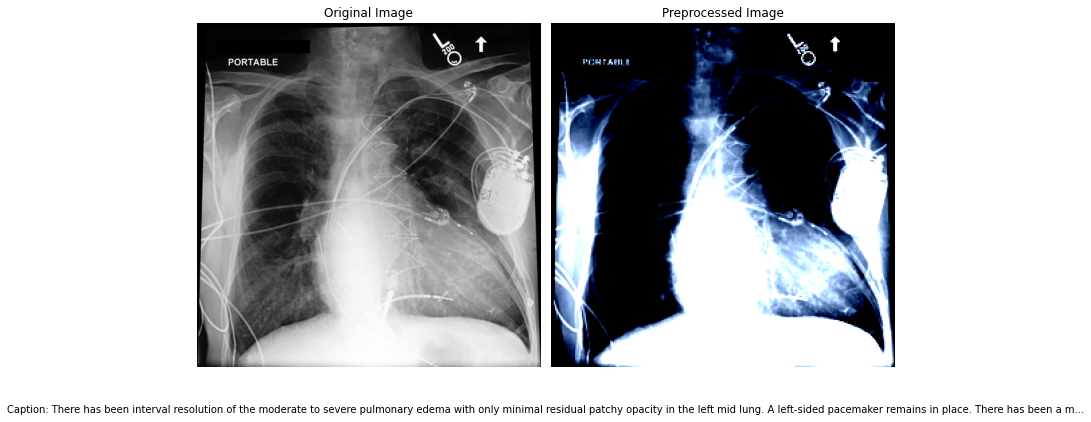

In [14]:
# Preprocess
processed = preprocess(sample)

# Visualize
visualize_preprocessed(sample, processed)


In [13]:
# !pip install open-clip-torch

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
def clean_caption(caption, max_tokens=120):
    if not caption:
        return ""

    tokens = caption.strip().split()
    if len(tokens) > max_tokens:
        caption = " ".join(tokens[:max_tokens]) + "..."

    # Basic cleanup
    caption = caption.replace("..", ".").replace("...", ".")
    return caption.strip()


### Creating Custom Dataset

In [17]:
from torch.utils.data import Dataset


class MimicCXRCaptionDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, image_preprocess, use_text=False, max_length=128):
        self.dataset = hf_dataset
        self.transform = transform
        self.tokenizer = tokenizer
        self.image_preprocess = image_preprocess
        self.max_length = max_length
        self.use_text = use_text  # if True, use 'text' instead of 'report'
        

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample["image"].convert("RGB")
        caption = sample["text"] if self.use_text else sample["report"]
#         caption = sample["report"]
        caption = clean_caption(caption)

        image_tensor = self.image_preprocess(image)

        tokenized = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "image": image_tensor,
            "input_ids": tokenized["input_ids"].squeeze(0),
            "attention_mask": tokenized["attention_mask"].squeeze(0),
            "caption": caption
        }

In [17]:
# !pip install sacremoses

In [33]:
# Load MimicCXR from Kaggle
dataset = load_dataset("hongrui/mimic_chest_xray_v_1")["train"].select(range(1000))

# Load BioMedCLIP image encoder + preprocessing
biomedclip_model, biomedclip_preprocess = open_clip.create_model_from_pretrained(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)

# Load BioGPT tokenizer
decoder_tokenizer = AutoTokenizer.from_pretrained("microsoft/BioGPT")
biogpt = BioGptForCausalLM.from_pretrained("microsoft/BioGPT").to(device)

In [34]:
mimic_dataset = MimicCXRCaptionDataset(
    hf_dataset=dataset,
    tokenizer=decoder_tokenizer,
    image_preprocess=biomedclip_preprocess,
    use_text=False  # or True if you want the shorter version
)

# Test a sample
sample = mimic_dataset[0]
print("Image shape:", sample["image"].shape)
print("Input IDs shape:", sample["input_ids"].shape)
print("Caption:", sample["caption"])

Image shape: torch.Size([3, 224, 224])
Input IDs shape: torch.Size([128])
Caption: Lung volumes are low. Retrocardiac opacity with silhouetting of the left hemidiaphragm and lateral border of the descending aorta is nonspecific and could reflect any of a combination of atelectasis, focal pneumonia or even a small effusion. Right infrahilar opacity with slight indistinctness of the right heart border could reflect infection in the appropriate clinical scenario. Apparent elevation of the right hemidiaphragm may be related to positioning and technique versus volume loss. There is cardiomegaly, but no CHF. Aortic calcifications are present. No pneumothorax.


In [35]:
import torch.nn as nn

class BioMedCLIPCaptioner(nn.Module):
    def __init__(self, image_encoder, text_decoder, embed_dim=512, gpt_hidden=1024):
        super().__init__()
        self.image_encoder = image_encoder
        self.decoder = text_decoder
        self.projector = nn.Linear(embed_dim, gpt_hidden)  # Project to decoder input space

    def forward(self, images, decoder_input_ids, attention_mask=None, labels=None):
        with torch.no_grad():
            image_features = self.image_encoder.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        image_context = self.projector(image_features).unsqueeze(1)
        
        decoder_inputs = self.decoder.get_input_embeddings()(decoder_input_ids)
        decoder_inputs = torch.cat([image_context, decoder_inputs[:, :-1, :]], dim=1)

        outputs = self.decoder(inputs_embeds=decoder_inputs, attention_mask=attention_mask, labels=labels)
        return outputs


T5 Generator

In [36]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    mimic_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=8,        # Set lower if you're using Jupyter/Windows
    pin_memory=torch.cuda.is_available()  # Safe GPU boost
)


### Caption Generating code

In [37]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from tqdm import tqdm

# Initialize model
caption_model = BioMedCLIPCaptioner(
    image_encoder=biomedclip_model,
    text_decoder=biogpt,
    embed_dim=512,
    gpt_hidden=biogpt.config.hidden_size
).to(device)

# Set up optimizer and loss
optimizer = AdamW(caption_model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(ignore_index=decoder_tokenizer.pad_token_id)

# Training loop
def train_captioner(model, dataloader, tokenizer, optimizer, device, epochs=3):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0.0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass with labels = input_ids for teacher forcing
            outputs = model(images, decoder_input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"📘 Epoch {epoch+1} — Loss: {avg_loss:.4f}")


In [38]:
train_captioner(
    model=caption_model,
    dataloader=dataloader,
    tokenizer=decoder_tokenizer,
    optimizer=optimizer,
    device=device,
    epochs=15  # or more depending on compute
)

Epoch 1/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 1 — Loss: 3.0940


Epoch 2/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 2 — Loss: 1.7939


Epoch 3/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 3 — Loss: 1.5442


Epoch 4/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 4 — Loss: 1.3296


Epoch 5/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 5 — Loss: 1.1267


Epoch 6/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 6 — Loss: 0.9320


Epoch 7/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 7 — Loss: 0.7550


Epoch 8/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 8 — Loss: 0.6082


Epoch 9/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 9 — Loss: 0.4894


Epoch 10/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 10 — Loss: 0.3961


Epoch 11/15: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


📘 Epoch 11 — Loss: 0.3289


Epoch 12/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 12 — Loss: 0.2822


Epoch 13/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 13 — Loss: 0.2509


Epoch 14/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


📘 Epoch 14 — Loss: 0.2229


Epoch 15/15: 100%|██████████| 125/125 [00:57<00:00,  2.18it/s]

📘 Epoch 15 — Loss: 0.2158


In [40]:
torch.save(caption_model.state_dict(), "BioMedCLIPCaptioner.pth")

top-k

In [41]:
def generate_caption(model, image_tensor, tokenizer, max_length=50, do_sample=True, top_k=50, top_p=0.95):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)

        image_features = model.image_encoder.encode_image(image_tensor)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        image_context = model.projector(image_features).unsqueeze(1)

        input_ids = torch.tensor([[tokenizer.eos_token_id or tokenizer.pad_token_id]], device=device)

        generated = input_ids
        for _ in range(max_length):
            decoder_inputs = model.decoder.get_input_embeddings()(generated)
            decoder_inputs = torch.cat([image_context, decoder_inputs], dim=1)

            outputs = model.decoder(inputs_embeds=decoder_inputs)
            logits = outputs.logits[:, -1, :]

            if do_sample:
                # Apply top-k and top-p sampling
                probs = torch.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)

            generated = torch.cat((generated, next_token), dim=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

        return tokenizer.decode(generated[0], skip_special_tokens=True)


In [51]:
# !pip install evaluate nltk
# !pip install rouge_score

In [43]:
import evaluate
import nltk
# nltk.download('punkt_tab')
# nltk.download('punkt', download_dir='/tmp/nltk_data')

In [44]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

In [45]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

def evaluate_caption(generated_caption, reference_caption):
    prediction_tokens = word_tokenize(generated_caption.lower())
    reference_tokens = word_tokenize(reference_caption.lower())

    # NLTK BLEU
    smoothie = SmoothingFunction().method4
    bleu = sentence_bleu(
        [reference_tokens],  # list of references
        prediction_tokens,
        smoothing_function=smoothie
    )

    # Huggingface ROUGE (expects raw string)
    rouge_result = rouge.compute(
        predictions=[generated_caption],
        references=[reference_caption]
    )

    return {
        "BLEU": bleu,
        "ROUGE-L": rouge_result["rougeL"]
    }


In [55]:
def evaluate_model_on_dataset(model, dataset, tokenizer, num_samples=50):
    total_bleu = 0.0
    total_rouge = 0.0

    results = []

    for i in range(min(num_samples, len(dataset))):
        sample = dataset[i]
        generated = generate_caption(model, sample["image"], tokenizer)
        reference = sample["caption"]

        scores = evaluate_caption(generated, reference)
        total_bleu += scores["BLEU"]
        total_rouge += scores["ROUGE-L"]

        results.append({
            "index": i,
            "generated": generated,
            "reference": reference,
            "bleu": scores["BLEU"],
            "rouge": scores["ROUGE-L"]
        })

    avg_bleu = total_bleu / num_samples
    avg_rouge = total_rouge / num_samples

    print(f"\n📊 Average BLEU:     {avg_bleu:.4f}")
    print(f"📊 Average ROUGE-L: {avg_rouge:.4f}")

    return results


In [56]:
results = evaluate_model_on_dataset(
    model=caption_model,
    dataset=mimic_dataset,
    tokenizer=decoder_tokenizer,
    num_samples=200
)



📊 Average BLEU:     0.0090
📊 Average ROUGE-L: 0.1191


In [57]:
# Sort by ROUGE-L score (descending)
sorted_results = sorted(results, key=lambda x: x["rouge"], reverse=True)

print("\n✅ BEST CAPTION EXAMPLE (ROUGE):")
print("📝 Generated:", sorted_results[0]["generated"])
print("📘 Ground Truth:", sorted_results[0]["reference"])
print(f"📊 ROUGE-L: {sorted_results[0]['rouge']:.4f}")



✅ BEST CAPTION EXAMPLE (ROUGE):
📝 Generated: is to right a tube the terminat the of stomach side is beyond esophagjunction The should advanced approximately cm more placement desired Respiratory is to worse the. improvement pulmonary, edema and asifrom small effusions A central line the terminat the of SVC appropriate aparin
📘 Ground Truth: As compared to the previous radiograph, the position of the left-sided PICC line is unchanged. The tip continues to project over the cavoatrial junction. There is no pneumothorax. The lung volumes remain low. Moderate atelectasis at the left and the right lung bases. Borderline size of the cardiac silhouette without pulmonary edema.
📊 ROUGE-L: 0.2268
